## Домашнее задание Lesson 3

Обучить полиномиальную регрессию, построить зависимость предсказанного от реального значения и рассчитать ошибку (всё для обучающей и тестовой выборок) для датасета сталей и предсказать предел текучести (0.2% Proof Stress (MPa)) на основании состава и температуры. Для большого числа признаков использовать регуляризацию. Постараться достичь минимально возможной ошибки на тестовой выборке. 

По желанию можно использовать кросс-валидацию для расчет метрики ошибки и поиск по сетке для подбора параметров регуляризации. Также можно самим реализовать алгоритм градиентного спуска и с его помощью рассчитать ошибку.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("Steels_kaggle.csv")
print(df.shape)

cols = df.columns
y = df[cols[16]]
x = df.drop(np.hstack([cols[16:], cols[0]]), axis=1)
feat = cols[1:16]


(915, 20)


Попытка проверить данные на выбросы

<Axes: >

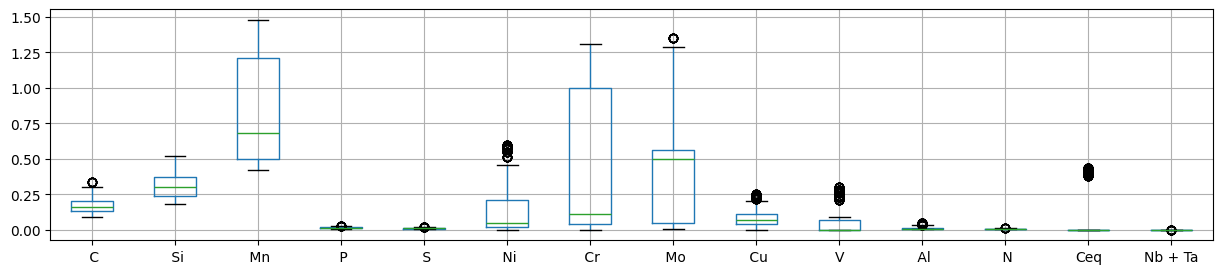

In [3]:
plt.figure(figsize=(15, 3))
df[feat[:-1]].boxplot()

In [4]:
for pos, i in enumerate(feat):
    q1 = np.quantile(x[i], q=0.25)
    q3 = np.quantile(x[i], q=0.75)
    outliers = []
    for num, j in enumerate(x[i]):
        if j < q1 - 1.5 * (q3 - q1) or j > q3 + 1.5 * (q3 - q1):
            outliers.append(num)
    print(f"{i} {pos} : {len(outliers)}")

 C 0 : 9
 Si 1 : 0
 Mn 2 : 0
 P 3 : 20
 S 4 : 29
 Ni 5 : 61
 Cr 6 : 0
 Mo 7 : 10
 Cu 8 : 49
V 9 : 180
 Al 10 : 110
 N 11 : 9
Ceq 12 : 210
Nb + Ta 13 : 22
 Temperature (°C) 14 : 0


In [5]:
cols = df.columns
y = df[cols[16]]
x = df.drop(np.hstack([cols[16:], cols[0]]), axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=49)

x_train_ = x_train.drop(["V", " Al", "Ceq"], axis=1)
x_test_ = x_test.drop(["V", " Al", "Ceq"], axis=1)

scaler = StandardScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler.fit(x_train_)
x_train_ = scaler.transform(x_train_)
x_test_ = scaler.transform(x_test_)


In [6]:
lr = SGDRegressor()
lr_ = SGDRegressor()

lr.fit(x_train, y_train)
lr_.fit(x_train_, y_train)

y_pred = lr.predict(x_test)
y_pred_ = lr_.predict(x_test_)

print(f"mse={mse(y_pred, y_test)}, mse_={mse(y_pred_, y_test)}")


mse=2703.260926392488, mse_=4065.454712821298


просто отбросить признаки, где много выбросов, нельзя

In [7]:
out_cols = ["V", " Al", "Ceq"]
for i in out_cols:
    t = x[i]
    q1 = np.quantile(t, q=0.25)
    q3 = np.quantile(t, q=0.75)
    flag1 = t < q1 - 1.5 * (q3 - q1)
    flag2 = t > q3 + 1.5 * (q3 - q1)
    flag3 = t <= q3 + 1.5 * (q3 - q1)
    print(q1, q3)
    print(np.mean(y[flag1]), np.std(y[flag1]))
    print(np.mean(y[flag2]), np.std(y[flag2]), np.sum(flag2))
    print(np.mean(y[flag3]), np.std(y[flag3]), np.sum(flag3))

0.0 0.07
nan nan
476.2111111111111 111.69352855464659 180
291.9755102040816 108.72547692340873 735
0.004 0.016
nan nan
418.7 103.67269737890581 110
315.85465838509316 130.15076778135366 805
0.0 0.0
nan nan
403.7857142857143 108.30330771765483 210
305.709219858156 129.49640259014356 705


разница для средних значений при группировке по выбросам есть, но ничего, оставим как есть

теперь только задание

In [8]:
y = df[cols[16]]
x = df.drop(np.hstack([cols[16:], cols[0]]), axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=49)

pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(include_bias=False)),
        ("regression", SGDRegressor(fit_intercept=True, max_iter=10**8, tol=1e-5)),
    ]
)

param_grid = [
    {
        "poly__degree": [1, 2, 3],
        "regression__penalty": ["elasticnet"],
        "regression__l1_ratio": [0, 0.25, 0.5, 0.75, 1.0],
        "regression__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 25, 50, 75, 100]
    }
]

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(x_train, y_train)

/home/tumen/notebook/jupyterenv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('regression',
                                        SGDRegressor(max_iter=100000000,
                                                     tol=1e-05))]),
             param_grid=[{'poly__degree': [1, 2, 3],
                          'regression__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5,
                                                10, 25, 50, 75, 100],
                          'regression__l1_ratio': [0, 0.25, 0.5, 0.75, 1.0],
                          'regression__penalty': ['elasticnet']}])

In [10]:
y_pred = grid.best_estimator_.predict(x_test)
print(f"mse={mse(y_test, y_pred)}\nmape={mape(y_test, y_pred)}")
print(grid.best_params_)

mse=2669.18695179286
mape=0.1295039833637514
{'poly__degree': 1, 'regression__alpha': 0.001, 'regression__l1_ratio': 0.75, 'regression__penalty': 'elasticnet'}


лучшая модель - модель со степенью 1, скорее всего, причина этого - большое кол-во признаков при простой обработке 

просто обучим lr и посмотрим какие признаки самые важные

In [11]:
y = df[cols[16]]
x = df.drop(np.hstack([cols[16:], cols[0]]), axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=49)

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

lr = SGDRegressor(penalty="l1", alpha=1)
y_pred = lr.fit(x_train, y_train).predict(x_test)
print(f"mse = {mse(y_pred, y_test)}")
for i in zip(cols[1:16], lr.coef_):
    print(i)

mse = 2733.1435749012167
(' C', 1.872499921109585)
(' Si', 9.340836445317883)
(' Mn', 19.395025507753598)
(' P', -2.690908906195263)
(' S', 0.0)
(' Ni', 20.336581347346424)
(' Cr', 0.16137965297743118)
(' Mo', 38.35275769638072)
(' Cu', 0.0)
('V', 52.14202608820159)
(' Al', 5.47423594406017)
(' N', -4.950773365332122)
('Ceq', 40.536346331515105)
('Nb + Ta', 5.943459092911527)
(' Temperature (°C)', -63.485217195530296)


попробуем применить степенные параметры только к столбцам Ni, Mo, V, Ceq, T

In [12]:
y = df[cols[16]]
x = df.drop(np.hstack([cols[16:], cols[0]]), axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=49)
print(x_train.shape)

scaler = StandardScaler()
pf = PolynomialFeatures(degree=3, include_bias=False)

x_train_1 = scaler.fit_transform(x_train.drop([" Ni", " Mo", "V", "Ceq", " Temperature (°C)"], axis=1))
x_test_1 = scaler.transform(x_test.drop([" Ni", " Mo", "V", "Ceq", " Temperature (°C)"], axis=1))
print(x_train_1.shape)

x_train_2 = x_train[[" Ni", " Mo", "V", "Ceq", " Temperature (°C)"]]
x_test_2 = x_test[[" Ni", " Mo", "V", "Ceq", " Temperature (°C)"]]
print(x_train_2.shape)

x_train_poly = pf.fit_transform(scaler.fit_transform(x_train_2))
x_test_poly = pf.fit_transform(scaler.transform(x_test_2))
print(x_train_poly.shape)


(732, 15)
(732, 10)
(732, 5)
(732, 55)


In [13]:
x_train = np.hstack([x_train_1, x_train_poly])
x_test = np.hstack([x_test_1, x_test_poly])
print(x_train.shape)

(732, 65)


In [14]:
lr = SGDRegressor(penalty="l1", alpha=1)
y_pred = lr.fit(x_train, y_train).predict(x_test)
print(f"mse = {mse(y_pred, y_test)}\nmape={mape(y_test, y_pred)}")


mse = 1731.4076977058523
mape=0.09509597506420812


mse упало с 2700 до 1800

## 1.3. Задание: Датасет Steels Lesson 4

Итак, твое задание состоит в следующем:
1. Построй регрессор на основе метода опорных векторов. Для этого импортируй класс `sklearn.svm.SVR`
2. Обучи модель для предсказания `0.2% Proof Stress (MPa)` по составу стали и температуре, используя различные ядра: линейное, полиномиальное и гауссовское. Используй `StandardScaler` для скейлинга признаков. Влияет ли его наличие на качество модели? Попробуй объяснить результат.
3. Найди для каждого из ядер наилучшие параметры: (`C, degree, coef0`) для полиномиального ядра, (`gamma, C`) для гауссовского.
4. Постарайся достигнуть наименьшей ошибки на тестовой выборке. Какая комбинация ядра и параметров дает наименьшую ошибку?

In [42]:
from sklearn.svm import SVR

y = df[cols[16]]
x = df.drop(np.hstack([cols[16:], cols[0]]), axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=49)

In [16]:
def svr_models (x_train, y_train, x_test, y_test):
    svr_linear = SVR(kernel="linear")
    svr_poly = SVR(kernel="poly", degree=3)
    svr_rbf = SVR(kernel="rbf")
    models = [svr_linear, svr_poly, svr_rbf]
    kernels = ["lin", "poly", "rbf"]
    for i in range(0, 3):
        y_pred = models[i].fit(x_train, y_train).predict(x_test)
        print(f"kernel: {kernels[i]}, mse: {mse(y_test, y_pred)}")


In [17]:
svr_models(x_train, y_train, x_test, y_test)

kernel: lin, mse: 7847.821713777324
kernel: poly, mse: 17903.268848932217
kernel: rbf, mse: 19497.253124559054


In [18]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
svr_models(x_train, y_train, x_test, y_test)

kernel: lin, mse: 2742.1317031764165
kernel: poly, mse: 12250.658393030488
kernel: rbf, mse: 12346.581558919142


нормализация признаков улучшает качество моделей, это связано с тем, что без нормализации в данных может быть разный масштаб

In [20]:
linear = SVR(kernel="linear")
param_grid = [
    {
        "C": np.linspace(1e-5, 1e1, 10)
    }
]
grid = GridSearchCV(linear, param_grid=param_grid, cv=5)
y_pred = grid.fit(x_train, y_train).best_estimator_.predict(x_test)
print(f"kernel: {linear}, mse: {mse(y_test, y_pred)}, mape: {mape(y_test, y_pred)}")
print(grid.best_params_)

kernel: SVR(kernel='linear'), mse: 2671.277178980884, mape: 0.12576455089946975
{'C': 5.55556}


In [22]:
poly = SVR(kernel="poly", max_iter=100000, tol=1e-3)
param_grid = [
    {
        "C": [0.0001, 0.001, 0.01, 0.1, 1],
        "degree": [2, 3, 4, 5],
        "coef0": [0.0001, 0.001, 0.01, 0.1, 0, 1],
    }
]
grid = GridSearchCV(poly, param_grid=param_grid, cv=5)
y_pred = grid.fit(x_train, y_train).best_estimator_.predict(x_test)
print(f"kernel: {poly}, mse: {mse(y_test, y_pred)}, mape: {mape(y_test, y_pred)}")
print(grid.best_params_)

kernel: SVR(kernel='poly', max_iter=100000), mse: 1805.6041028507943, mape: 0.09161405566560016
{'C': 1, 'coef0': 1, 'degree': 5}


In [23]:
rbf = SVR(kernel="rbf", max_iter=100000, tol=1e-3)
param_grid = [
    {
        "C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 25, 100, 400, 500, 600, 700, 800],
        "gamma":np.linspace(0.001, 1, 10)
    }
]
grid = GridSearchCV(rbf, param_grid=param_grid, cv=5)
y_pred = grid.fit(x_train, y_train).best_estimator_.predict(x_test)
print(f"kernel: {rbf}, mse: {mse(y_test, y_pred)}, mape: {mape(y_test, y_pred)}")
print(grid.best_params_)

kernel: SVR(max_iter=100000), mse: 918.5834921398076, mape: 0.05768655084821767
{'C': 800, 'gamma': 0.112}


Наилучший результат у Гауссовского ядра с оптимальными параметрами $C = 800$, $gamma = 0.112$

**Задание**

1. Рассчитать score на кросс-валидации для моделей LinearRegression и CatBoost
2. Обучить нейронную сеть (MLPRegressor) и подобрать оптимальные гиперпараметры
3. Сравнить полученные score разных алгоритмов
4. Придумать новые признаки модели, которые будут давать меньшую ошибку на кросс-валидации



In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

df = pd.read_csv("Steels_kaggle.csv")
cols = df.columns
y = df[cols[16]]
x = df.drop(np.hstack([cols[16:], cols[0]]), axis=1)
feat = cols[1:16]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9999, random_state=49)

scaler = StandardScaler()
scaler.fit(x_traneg_mean_absolute_percentage_errorin)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape

(914, 15)

In [17]:
boost = GradientBoostingRegressor(max_depth=10, n_estimators=1000)
lr = LinearRegression()

scores_lr = cross_val_score(lr, x_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')
scores_boost = cross_val_score(boost, x_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')

In [18]:
print(f"lr: mape={-np.mean(scores_lr)}\nboosting: mape={-np.mean(scores_boost)}")

lr: mape=0.14777760644693916
boosting: mape=0.06968399085731833


In [30]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=10000, tol=0.1, hidden_layer_sizes=(7,), batch_size=7, activation="tanh")
scores_regr = cross_val_score(regr, x_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')

In [31]:
print(f"regr: mape={-np.mean(scores_regr)}")

regr: mape=0.09810293346245993


результаты по mape: LR=0.15; NN=0.10, SVR(kernel=rbf)=0.06, BOOSTING=0.07

In [49]:
# в прошлом задании мы оценивали важность признаков, к самым важным их них применим polyfit преобразование
y = df[cols[16]]
x = df.drop(np.hstack([cols[16:], cols[0]]), axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9999, random_state=49)
print(x_train.shape)

scaler = StandardScaler()
pf = PolynomialFeatures(degree=3, include_bias=False)

x_train_1 = scaler.fit_transform(x_train.drop([" Ni", " Mo", "V", "Ceq", " Temperature (°C)"], axis=1))
print(x_train_1.shape)
x_train_2 = x_train[[" Ni", " Mo", "V", "Ceq", " Temperature (°C)"]]
print(x_train_2.shape)
x_train_poly = pf.fit_transform(scaler.fit_transform(x_train_2))
print(x_train_poly.shape)

(914, 15)
(914, 10)
(914, 5)
(914, 55)


In [51]:
boost = GradientBoostingRegressor(max_depth=5, n_estimators=5000)
lr = LinearRegression()
rbf = SVR(kernel="rbf", max_iter=100000, tol=1e-3, C=10)

scores_lr = cross_val_score(lr, x_train_poly, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')
scores_boost = cross_val_score(boost, x_train_poly, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')
scores_rbf = cross_val_score(rbf, x_train_poly, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')

In [52]:
print(f"lr: mape={-np.mean(scores_lr)}\nboosting: mape={-np.mean(scores_boost)}\nrbf: mape={-np.mean(scores_rbf)}")

lr: mape=0.0923493753179764
boosting: mape=0.06990985791998497
rbf: mape=0.14631592731978887


улучшилась только линейная регрессия

In [55]:
from sklearn.decomposition import PCA

y = df[cols[16]]
x = df.drop(np.hstack([cols[16:], cols[0]]), axis=1)
alloy = df["Alloy code"]
pca = PCA(n_components=2)
pca.fit(x)
print(pca.explained_variance_ratio_)

[9.99984359e-01 1.04208706e-05]


In [71]:
x_reduce = pca.transform(x)

In [86]:
hex_colors = [
    "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF",
    "#00FFFF", "#FFFFFF", "#000000", "#808080", "#C0C0C0",
    "#FFA500", "#800080", "#A52A2A", "#FFC0CB", "#008000",
    "#000080", "#800000", "#808000", "#008080", "#FFD700",
    "#DC143C", "#B22222", "#8B0000", "#FF4500", "#FF6347",
    "#FA8072", "#E9967A", "#CD5C5C", "#F08080", "#FF7F50",
    "#FF69B4", "#FF1493", "#C71585", "#DB7093", "#FFB6C1",
    "#006400", "#228B22", "#32CD32", "#90EE90", "#98FB98",
    "#8FBC8F", "#00FA9A", "#00FF7F", "#3CB371", "#2E8B57",
    "#66CDAA", "#7FFFD4", "#20B2AA", "#5F9EA0", "#008B8B",
    "#4169E1", "#1E90FF", "#00BFFF", "#87CEEB", "#87CEFA",
    "#4682B4", "#5F9EA0", "#6495ED", "#7B68EE", "#6A5ACD",
    "#483D8B", "#191970", "#00008B", "#0000CD", "#ADD8E6",
    "#9370DB", "#8A2BE2", "#9400D3", "#9932CC", "#BA55D3",
    "#DA70D6", "#EE82EE", "#DDA0DD", "#D8BFD8", "#E6E6FA",
    "#F5F5DC", "#FFE4C4", "#FFEBCD", "#F5DEB3", "#DEB887",
    "#D2B48C", "#BC8F8F", "#A0522D", "#8B4513", "#D2691E",
    "#F0F8FF", "#F8F8FF", "#FAEBD7", "#FFF5EE", "#F0FFF0",
    "#FFF0F5", "#F5FFFA", "#FFFAF0", "#FFF8DC", "#FAFAD2"
]
colors = {np.unique(np.array(alloy))[i] : hex_colors[i] for i in range(0, len(np.unique(np.array(alloy))))}
len(colors)

95

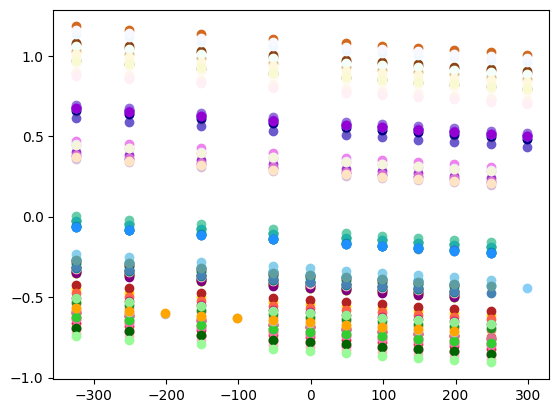

In [88]:
for i in range(0, len(alloy)):
    plt.scatter(x_reduce[i][0], x_reduce[i][1], color=colors[alloy[i]])

In [89]:
pca.components_

array([[-8.02767558e-06,  1.69470061e-05, -4.13138352e-05,
        -8.20179505e-07, -8.33893449e-08,  3.21727086e-05,
         2.22677733e-04,  1.79182971e-04,  7.62913640e-06,
         3.39092909e-05, -8.88402214e-07,  3.17961395e-07,
        -1.01989342e-05, -6.10427583e-08,  9.99999957e-01],
       [ 1.22225239e-02, -1.76962415e-03, -3.51540675e-01,
        -2.36188772e-03, -6.10129765e-05,  3.08124111e-02,
         7.02862641e-01,  5.84398487e-01,  2.05660821e-02,
         9.74296809e-02, -1.20905563e-02,  1.65012912e-03,
        -1.72364923e-01, -7.02849974e-05, -2.81844657e-04]])